## XGBoost Regression for Global CO2 Emissions Analysis and Prediction
### Project: Blazer 

We implement XGBoost regression model for using global population to predic the level of gloabl CO2 emissions.

The data includes global population and global CO2 emission from 1750 to 2020, and there are 45 missing population data, and we consider to drop them as they didn't have much influence to our model.

* As year increase, the number of population and total amount of CO2 emissions are also increase, which can imply there are positive relationship between population and CO2. 
* The overall climbing trend can be also observed in the line chart of Global CO2 Emissions and population from 1750 to 2020
* From histogram and boxplot, population and CO2 data are follwed right skewed.
* The statistical graphics can tell how rapid increase the population and CO2 emissions especially from 1900 to 2020.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error 
import xgboost as xgb

## 1. Loading dataset

In [2]:
df = pd.read_csv('owid-co2-data.csv')
df.head()

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1949,AFG,7624058.0,NaN,NaN,NaN,0.015,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1950,AFG,7752117.0,9.421400e+09,NaN,NaN,0.084,0.070,475.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1951,AFG,7840151.0,9.692280e+09,NaN,NaN,0.092,0.007,8.7,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1952,AFG,7935996.0,1.001733e+10,NaN,NaN,0.092,0.000,0.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1953,AFG,8039684.0,1.063052e+10,NaN,NaN,0.106,0.015,16.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [3]:
# extract data from only world level 
data = df[df["country"].isin(["World"])]
data = data[['year','population', 'co2']]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 25477 to 25747
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        271 non-null    int64  
 1   population  226 non-null    float64
 2   co2         271 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 8.5 KB


## 2. Descriptive statistics 

In [4]:
summary = data[['population', 'co2']].describe().transpose()
summary

,count,mean,std,min,25%,50%,75%,max
population,226.0,2.589392e+09,1.879929e+09,7.456645e+08,1.281684e+09,1.754469e+09,3.258232e+09,7.794789e+09
co2,271.0,6.260237e+03,9.943308e+03,9.351000e+00,4.953750e+01,1.009675e+03,6.556711e+03,3.670250e+04


## 3. Exploratory data analysis and statistical graphics

* Pair Plot

Text(0.5, 1.05, 'Pair Plot of population vs co2')

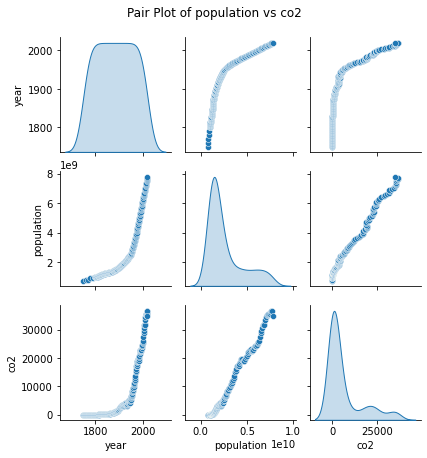

In [5]:
pair_plot = sns.pairplot(data, diag_kind="kde",height=2)
pair_plot.fig.suptitle("Pair Plot of population vs co2", y=1.05)

- Histogram

[Text(0.5, 1.0, 'Histogram of co2')]

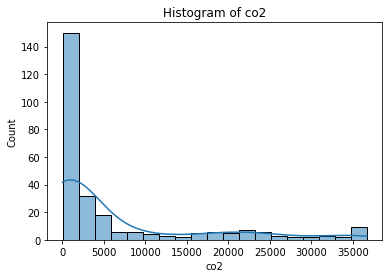

In [6]:
sns.histplot(data=data, x="co2", kde=True).set(title='Histogram of co2')

[Text(0.5, 1.0, 'Histogram of population')]

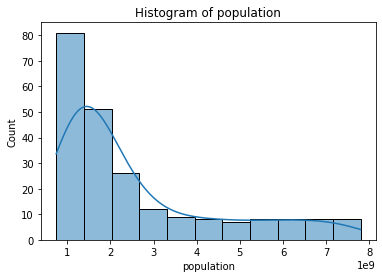

In [7]:
sns.histplot(data=data, x="population", kde=True).set(title='Histogram of population')

- Boxplot

[Text(0.5, 1.0, 'Boxplot of co2')]

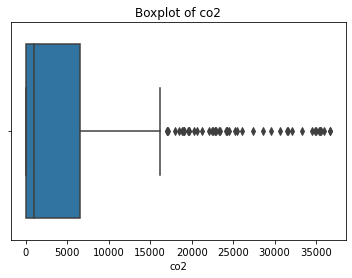

In [8]:
sns.boxplot(x=data["co2"]).set(title='Boxplot of co2')

[Text(0.5, 1.0, 'Boxplot of population')]

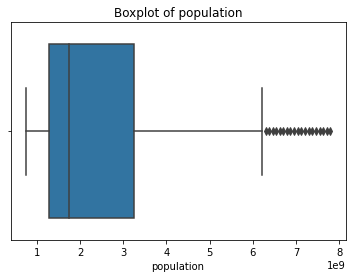

In [9]:
sns.boxplot(x=data["population"]).set(title='Boxplot of population')

- Line chart

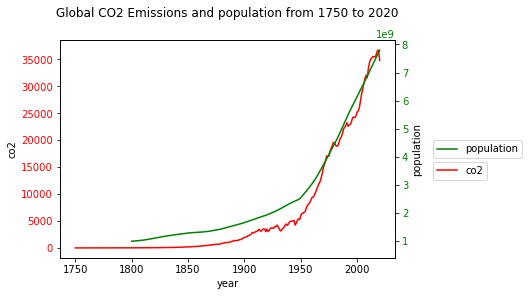

In [10]:
fig, ax = plt.subplots()

ax.plot(data['year'],data['co2'], color='red', label = 'co2')
ax.tick_params(axis='y', labelcolor='red')
plt.xlabel("year")  
plt.ylabel("co2") 

ax2 = ax.twinx()

ax2.plot(data['year'], data['population'], color='green', label = 'population')
ax2.tick_params(axis='y', labelcolor='green')
plt.ylabel("population") 
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.4))
ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.title("Global CO2 Emissions and population from 1750 to 2020", y=1.08)
plt.show()



## 4. Model

- Split data to trainset and testset 

In [11]:
# Since population has nan, we drop missing value

data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 25477 to 25747
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        226 non-null    int64  
 1   population  226 non-null    float64
 2   co2         226 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 7.1 KB


In [12]:
X, y = data['population'], data['co2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
# X_train, X_test, y_train, y_test = X.iloc[:-30], X.iloc[-30:], y.iloc[:-30], y.iloc[-30:]
# df.iloc[:3]

* Cross Validation


In [13]:
regressor=xgb.XGBRegressor(eval_metric='rmsle')

param_grid = {'alpha': [1e-3, 1e-2, 1e-1, 0, 1, 1.5],
              "max_depth": [3, 4, 5],
              "n_estimators": [10, 100, 200],
              "learning_rate": [0.01, 0.015]}

search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'alpha': 0.001, 'learning_rate': 0.015, 'max_depth': 5, 'n_estimators': 200}


* Fit model
  

In [14]:
xg =xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                     n_estimators  = search.best_params_["n_estimators"],
                     max_depth     = search.best_params_["max_depth"],
                    alpha = search.best_params_["alpha"])

xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)

In [15]:
print('R2 Value:',metrics.r2_score(y_test, y_pred))
rmse = np.sqrt(mean_squared_error (y_test, y_pred))
print("RMSE : % f" %(rmse))
mae = metrics.mean_absolute_error(y_test, y_pred)
print("MAE : % f" %(mae))
#Measuring accuracy on Testing Data
print('Accuracy',100- (np.mean(np.abs((y_test - y_pred) / y_test)) * 100))

R2 Value: 0.9884233252730543
RMSE :  1085.546643
MAE :  633.259429
Accuracy 89.87379509205462


* Plot results

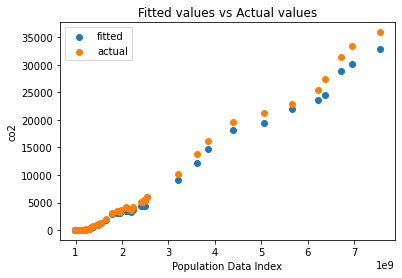

In [16]:
plt.scatter(X_test, y_pred, label = 'fitted')
plt.scatter(X_test, y_test, label = 'actual')
plt.xlabel("Population Data Index") 
plt.ylabel("co2")  
plt.title("Fitted values vs Actual values")
plt.legend()
plt.show()